# CMEMS Arctic Ocean Physics Reanalysis

Remotely susbet CMEMS Arctic Ocean Physics Reanalysis dataset

In [1]:
import copernicusmarine
import geopandas as gpd
import pyproj
import shapely
import xarray as xr

# Requires Copernicus Marine account: https://data.marine.copernicus.eu/register
copernicusmarine.login(skip_if_user_logged_in=True)

# Get subset bounds by buffering combined bbox of sampling points
sample_points = gpd.read_file("../data/ocean/ocean_sample_points.geojson")
sample_bbox = gpd.GeoSeries(shapely.geometry.box(*sample_points.total_bounds)).set_crs(3413)
sample_bbox = sample_bbox.buffer(50_000, cap_style="square", join_style="mitre").to_crs(4326)
x_min, y_min, x_max, y_max = sample_bbox.total_bounds

# Remotely access TOPAZ ocean potential temperature data
topaz_ds = copernicusmarine.open_dataset(
    dataset_id="cmems_mod_arc_phy_my_topaz4_P1M",
    dataset_version="202012",
    variables=["thetao"],
    minimum_latitude=y_min,
    minimum_longitude=x_min,
    maximum_latitude=y_max,
    maximum_longitude=x_max,
    start_datetime="1991-01-01T00:00:00",
    end_datetime="2024-01-01T00:00:00",
    minimum_depth=0,
    maximum_depth=500,
)

INFO - 2024-07-03T09:43:04Z - You are already logged in. Skipping login.


Fetching catalog: 100%|██████████| 3/3 [00:09<00:00,  3.18s/it]


INFO - 2024-07-03T09:43:16Z - You forced selection of dataset version "202012"
INFO - 2024-07-03T09:43:16Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-07-03T09:43:20Z - Service was not specified, the default one was selected: "arco-time-series"
WARNING - 2024-07-03T09:43:22Z - Some or all of your subset selection [1991-01-01 00:00:00, 2024-01-01 00:00:00] for the time dimension  exceed the dataset coordinates [1991-01-01 00:00:00, 2022-12-01 00:00:00]


Sample TOPAZ ocean potential temperature

In [7]:
# To store sampled Datasets
ocean_ds = []

# Group sampling points by corresponding glacier
for glacier, point in sample_points.groupby(by="glacier"):
    # Construct 50x50km sampling box around point
    x = point.geometry.x.item()
    y = point.geometry.y.item()
    transformer = pyproj.Transformer.from_crs("EPSG:3413", "EPSG:4326")
    x_min, y_min = transformer.transform(x - 25000, y - 25000)
    x_max, y_max = transformer.transform(x + 25000, y + 25000)
    x_slice = slice(x_min, x_max)
    y_slice = slice(y_min, y_max)

    # Subset reanalysis dataset by sampling box
    temperature_ds = topaz_ds.sel(latitude=x_slice, longitude=y_slice)

    # Sample ocean potential temperature by taking median value of 50km sampling box
    temperature_ds["thetao"] = temperature_ds.thetao.median(dim=["latitude", "longitude"]).assign_attrs(
        temperature_ds.thetao.attrs
    )
    temperature_ds = temperature_ds.rename(thetao="temperature")

    # Calculate baseline average and time series anomalies
    temperature = temperature_ds.temperature
    temperature_baseline = temperature_ds.temperature.groupby("time.month").mean()
    temperature_anomaly = temperature.groupby("time.month") - temperature_baseline

    # Store anomalies as new variable
    temperature_ds = temperature_ds.assign(temperature_anomaly=temperature_anomaly.drop_vars("month"))

    # Assign dimensions of current point and swap lat/lon for projected coords of sampling point
    temperature_ds = temperature_ds.drop_dims(drop_dims=["latitude", "longitude"])
    temperature_ds = temperature_ds.expand_dims(dim="glacier")
    temperature_ds = temperature_ds.assign_coords(
        glacier=("glacier", [glacier]),
        x=(("glacier"), [x]),
        y=(("glacier"), [y]),
    )
    ocean_ds.append(temperature_ds)


# Concat sampled Datasets and write to disk
ocean_ds = xr.combine_by_coords(ocean_ds, combine_attrs="drop_conflicts")
ocean_ds.to_netcdf("../data/ocean/ocean_temp_monthly_1991_2022.nc")
ocean_ds

<xarray.Dataset> Size: 163kB
Dimensions:              (glacier: 2, time: 384, depth: 26)
Coordinates:
  * depth                (depth) float32 104B 0.0 2.0 4.0 ... 400.0 450.0 500.0
  * time                 (time) datetime64[ns] 3kB 1991-01-01 ... 2022-12-01
  * glacier              (glacier) <U24 192B 'DAUGAARD-JENSEN' 'UNNAMED_UUNAR...
    x                    (glacier) float64 16B 8.909e+05 5.695e+05
    y                    (glacier) float64 16B -1.991e+06 -2.428e+06
Data variables:
    temperature          (glacier, time, depth) float32 80kB -1.833 ... nan
    temperature_anomaly  (glacier, time, depth) float32 80kB 0.00563 ... nan
Attributes:
    Conventions:  CF-1.4
    field_date:   1991-01-15
    field_type:   Files based on file type nersc_weekly
    history:      20220830:Created by program hyc2proj, version V0.3
    institution:  NERSC, Jahnebakken 3, N-5007 Bergen, Norway
    references:   http://topaz.nersc.no
    source:       NERSC-HYCOM model fields
    title:        Arctic Ocean Physics Reanalysis
    version:      v4b

Quick visualisation of ocean temperature time series at depth of 5 and 400 metres

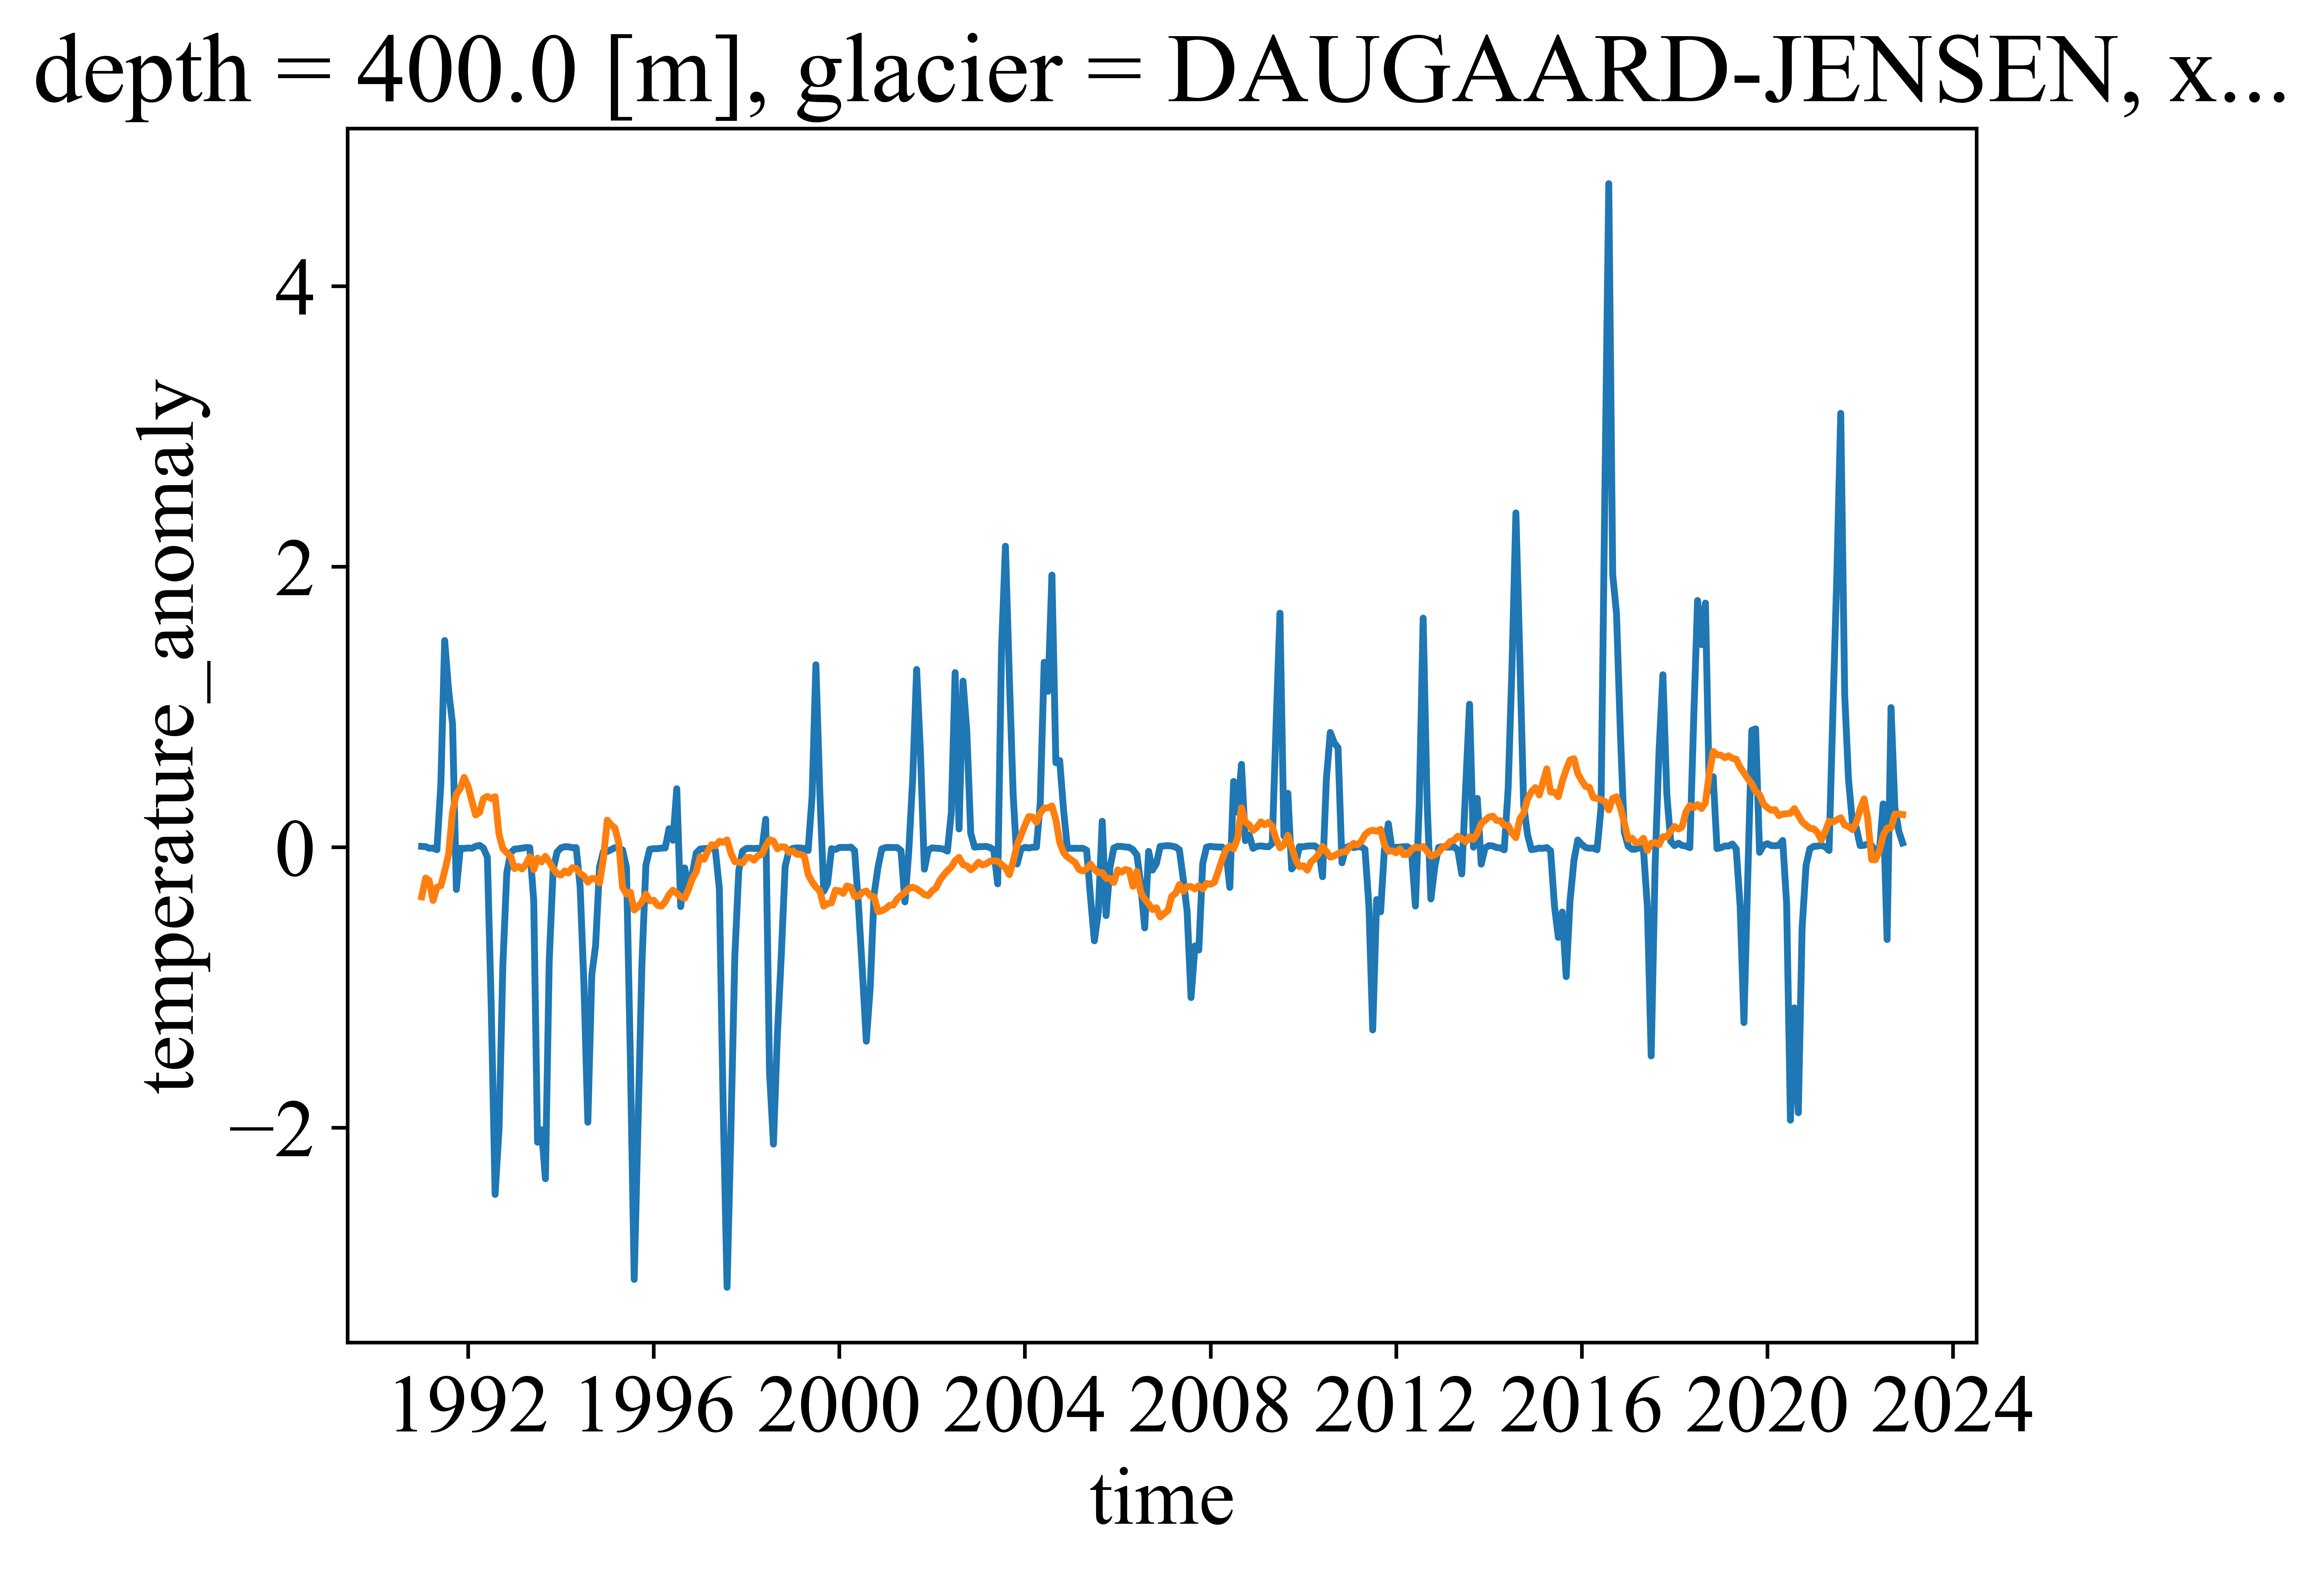

In [46]:
ocean_ds.isel(glacier=0).sel(depth=6).temperature_anomaly.plot()
ocean_ds.isel(glacier=0).sel(depth=400).temperature_anomaly.plot()

Linear regression of ocean temperature agaisnt time

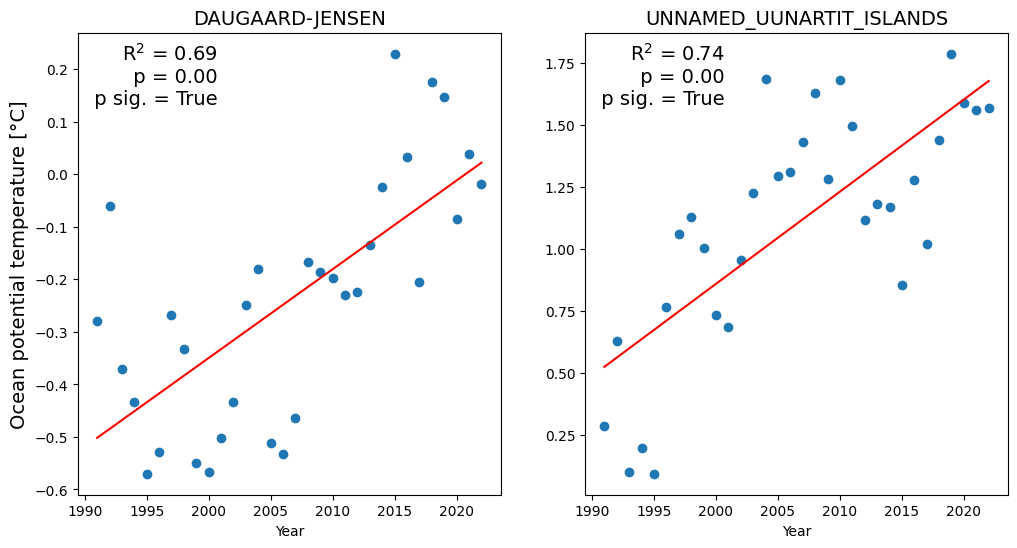

In [15]:
import matplotlib.pyplot as plt
import scipy
import xarray as xr
from matplotlib.gridspec import GridSpec
from matplotlib.offsetbox import AnchoredText

# Set up axes
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(nrows=1, ncols=2, width_ratios=(1, 1))
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
axs = [ax0, ax1]

# Load sampled ocean temperature data
ocean_ds = xr.open_dataset("../data/ocean/ocean_temp_monthly_1991_2022.nc")

for i, (glacier, ds) in enumerate(ocean_ds.groupby("glacier", squeeze=False)):
    # temperature = ds.sel(depth=5, method="nearest").squeeze()
    temperature = ds.sel(depth=slice(200, 400)).mean(dim="depth").squeeze()

    temperature = temperature.temperature.resample(time="1YS").mean()
    years = temperature.time.dt.year

    mask = temperature.notnull() & years.notnull()
    temperature = temperature.where(mask, drop=True)
    years = years.where(mask, drop=True)

    # Regress terminus change against year
    res = scipy.stats.linregress(years, temperature)

    # Plot data and trendline
    axs[i].plot(years, temperature, "o")
    axs[i].plot(years, res.intercept + res.slope * years, "r", label="fitted line")

    # Add R2 and p values to plot
    axs[i].add_artist(
        AnchoredText(
            f"R$^{{2}}$ = {res.rvalue:.2f}\n p = {res.pvalue:.2f}\n p sig. = {res.pvalue < 0.05}",
            loc="upper left",
            borderpad=0.1,
            prop=dict(fontsize=14, horizontalalignment="right"),
            frameon=False,
        )
    )

    # Label plots
    axs[i].set_title(glacier, fontsize=14)
    axs[i].set_xlabel("Year")

axs[0].set_ylabel("Ocean potential temperature [\N{DEGREE SIGN}C]", size=14)

plt.show()

Plot of ocean temperature and anomaly relative to the 1991-2024 baseline

In [41]:
import matplotlib.pyplot as plt
import xarray as xr
from matplotlib.dates import DateFormatter, YearLocator
from matplotlib.gridspec import GridSpec
from matplotlib.offsetbox import AnchoredText

PLOT_SETTINGS = {
    "DAUGAARD-JENSEN": {
        "colour": [(0.122, 0.467, 0.706, 1.0), (0.122, 0.467, 0.706, 0.25)],
        "label": "Daugaard-Jensen",
    },
    "UNNAMED_UUNARTIT_ISLANDS": {
        "colour": [(1.0, 0.498, 0.055, 1.0), (1.0, 0.498, 0.055, 0.25)],
        "label": "Uunartit Islands",
    },
}

# Global plot settings
plt.rcParams["figure.dpi"] = 1000
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 18
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18

# Set up axes
fig = plt.figure(figsize=(16, 12))
gs = GridSpec(nrows=2, ncols=1)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0])
axs = [ax0, ax1]

# Read temperature time series produced above from disk
ocean_ds = xr.open_dataset(f"../data/ocean/ocean_temp_monthly_1991_2022.nc")

# Plot data for each glacier in turn
for glacier, ds in ocean_ds.groupby("glacier", squeeze=False):
    temperature = ds.sel(depth=slice(200, 400)).mean(dim="depth").squeeze()
    # temperature = ds.sel(depth=5, method="nearest").squeeze()
    # Plot monthly mean surface air temperature
    axs[0].plot(
        temperature.temperature.time,
        temperature.temperature,
        color=PLOT_SETTINGS[glacier]["colour"][0],
        linewidth=2,
        label=PLOT_SETTINGS[glacier]["label"],
    )

    # Plot anomalies of monthly mean surface air temperature
    axs[1].plot(
        temperature.temperature_anomaly.time,
        temperature.temperature_anomaly,
        linestyle="-",
        linewidth=2,
        color=PLOT_SETTINGS[glacier]["colour"][0],
        label=PLOT_SETTINGS[glacier]["label"],
    )

# Set y-axis range to fit data and add label
axs[0].set_ylim(bottom=-1, top=3)
axs[0].set_ylabel("Mean ocean potential temperature\n at 200-400 m [\N{DEGREE SIGN}C]", labelpad=20)
axs[1].set_ylim(bottom=-2, top=1.5)
axs[1].set_ylabel("Mean ocean potential temperature\n anomaly at 200-400 m [\N{DEGREE SIGN}C]", labelpad=20)

# Set x-axis range to fit data
axs[0].set_xlim(pd.to_datetime("1985-01-01"), pd.to_datetime("2024-01-01"))
axs[1].set_xlim(pd.to_datetime("1985-01-01"), pd.to_datetime("2024-01-01"))

# Format x-axis ticks: text format, frequency, rotation
axs[0].xaxis.set_major_formatter(DateFormatter("%Y"))
axs[0].xaxis.set_major_locator(YearLocator(5))
axs[0].xaxis.set_minor_locator(YearLocator(1))
axs[0].tick_params(labelbottom=False)
axs[1].xaxis.set_major_formatter(DateFormatter("%Y"))
axs[1].xaxis.set_major_locator(YearLocator(5))
axs[1].xaxis.set_minor_locator(YearLocator(1))
axs[1].tick_params(axis="x", rotation=70)

# Remove margin gap
axs[0].margins(x=0)
axs[1].margins(x=0)

# Draw horizontal line at y=0
axs[0].axhline(y=0, c="black", alpha=0.7, linewidth=0.7, zorder=1, linestyle=(0, (6, 8)))
axs[1].axhline(y=0, c="black", alpha=0.7, linewidth=0.7, zorder=1, linestyle=(0, (6, 8)))

# Draw grid
axs[0].grid(True, which="both", axis="both", c="gray", linestyle=":", linewidth=0.5, alpha=0.8, zorder=0)
axs[1].grid(True, which="both", axis="both", c="gray", linestyle=":", linewidth=0.5, alpha=0.8, zorder=0)

# Draw axes label
axs[0].add_artist(AnchoredText("(a)", loc="upper left", borderpad=0.1, prop=dict(weight="semibold"), frameon=False))
axs[1].add_artist(AnchoredText("(b)", loc="upper left", borderpad=0.1, prop=dict(weight="semibold"), frameon=False))


plt.tight_layout()
plt.savefig("../img/ocean_ts.png", dpi=fig.dpi, bbox_inches="tight")
plt.show()

# OMG CTDs

Search URL [DJ](https://search.earthdata.nasa.gov/search/granules?p=C2491772159-POCLOUD&pg[0][v]=f&pg[0][gsk]=-start_date&sb[0]=-29.49139%2C71.71297%2C-28.44456%2C71.92634&tl=1719227256.652!3!!&lat=71.58693720430232&long=-30.69140625&zoom=7)

Search URL [UI](https://search.earthdata.nasa.gov/search/granules?p=C2491772159-POCLOUD&pg[0][v]=f&pg[0][gsk]=-start_date&sb[0]=-34.42646%2C67.32710%2C-33.27379%2C67.44001&tl=1719227256.652!3!!&lat=67.33551225280294&long=-37.5380859375&zoom=6)

In [ ]:
import earthaccess
import matplotlib.pyplot as plt
import xarray as xr


earthaccess.login(strategy="interactive")

In [ ]:
ctds = earthaccess.search_data(
    short_name="OMG_L2_AXCTD",
    bounding_box=(-29.07861, 71.64087, -27.29004, 72.37468),
)
ctds = earthaccess.open(ctds)

ctd_ds = []
for ctd in ctds:
    ctd = xr.open_dataset(ctd).load()
    ctd.temperature.plot(y="depth")
    plt.gca().invert_yaxis()
    ctd_ds.append(ctd)

# files = earthaccess.download(results, "./local_folder")

In [239]:
import numpy as np

max_obs_length = max(ds.sizes["obs"] for ds in ctds)
padded_datasets = [ds.pad(obs=(0, max_obs_length - ds.sizes["obs"]), constant_values=np.nan) for ds in ctds]

combined_ds = xr.concat(padded_datasets, dim="profile", combine_attrs="drop_conflicts")
combined_ds

<xarray.Dataset> Size: 2MB
Dimensions:         (profile: 5, obs: 9350)
Coordinates:
    lat             (profile) float32 20B 71.94 71.92 71.93 71.91 71.92
    lon             (profile) float32 20B -28.41 -28.29 -28.38 -28.56 -28.46
    time            (profile) datetime64[ns] 40B 2017-10-16T12:12:32 ... 2021...
    depth           (profile, obs) float32 187kB 0.72 0.8304 0.9409 ... nan nan
Dimensions without coordinates: profile, obs
Data variables:
    profile_time    (profile, obs) timedelta64[ns] 374kB 00:00:00 ... NaT
    frame           (profile, obs) |S8 374kB b'975471E4' b'975471E4' ... b'nan'
    temperature     (profile, obs) float32 187kB -0.67 -0.67 -0.67 ... nan nan
    conductivity    (profile, obs) float32 187kB 22.43 22.43 22.45 ... nan nan
    salinity        (profile, obs) float32 187kB 26.96 26.96 26.98 ... nan nan
    sound_velocity  (profile, obs) float32 187kB 1.435e+03 1.435e+03 ... nan nan
    density         (profile, obs) float32 187kB 1.022e+03 1.022e+03 ... nan nan
Attributes: (12/54)
    title:                           OMG Ocean AXCTD Level 2 Data
    summary:                         This file contains conductivity, tempera...
    keywords:                        Conductivity, Salinity, Water Depth, Wat...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    Conventions:                     CF-1.6, ACDD-1.3
    id:                              OMG_Ocean_AXCTD_L2
    ...                              ...
    cal_coefficient_state:           Original
    temperature_coefficient_3:       0.000000E+00
    temperature_coefficient_4:       0.000000E+00
    conductivity_coefficient_3:      0.000000E+00
    conductivity_coefficient_4:      0.000000E+00
    coefficient_comment:             Temperature and conductivity coefficient...

In [ ]:
xr.open_dataset("../data/ocean/OMG_Ocean_AXCTD_L2_20210820131357.nc").load().temperature.plot(y="depth")
t_ds.sel(glacier_code="DJ").sel(time="2021-08-20T00:00:00.000000000", method="nearest").thetao.plot(y="depth")

import matplotlib.pyplot as plt

plt.gca().invert_yaxis()

In [ ]:
# combined_ds["temp_mean"] = (
#     ("mean", "obs"),
#     [combined_ds.temperature.mean(dim="profile").values],
# )
# combined_ds.temp_mean.plot(y="obs", label="mean", c="black")

# combined_ds.sel(obs=slice(0, 1000)).temperature.mean(dim="profile").plot(y="obs", label="mean")

for _, d in combined_ds.groupby("profile"):
    sub_[0].sel(time=d.time.values, method="nearest").thetao.median(dim=["latitude", "longitude"]).plot(
        y="depth", c="blue"
    )

    print(
        sub_[0].sel(time=d.time.values, method="nearest").thetao.median(dim=["latitude", "longitude"]).mean(dim="depth")
    )
    d.temperature.plot(y="depth", label=d.time.values, c="red")


# plt.legend(loc="lower left")
plt.gca().invert_yaxis()

In [ ]:
import scipy

res = scipy.stats.linregress(c, r)

# plot the data itself
plt.plot(c, r, "o")
plt.plot(c, res.intercept + res.slope * c, "r", label="fitted line")